<IPython.core.display.Javascript object>


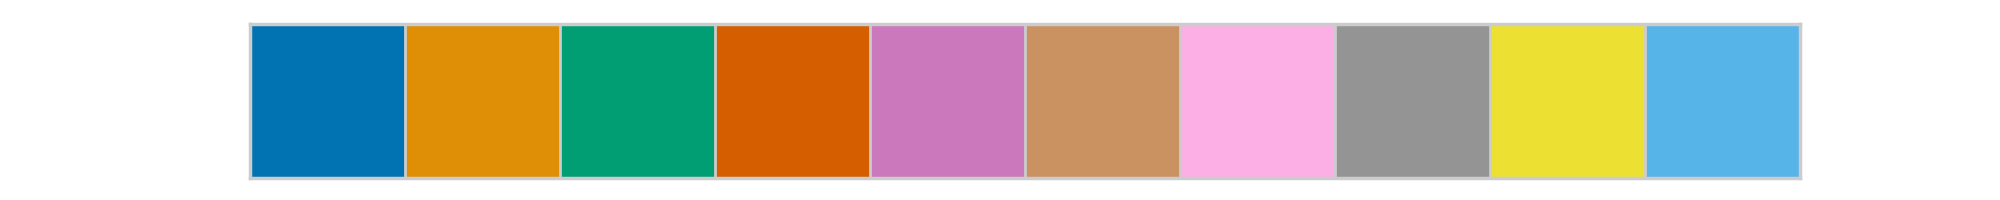

In [25]:
import numpy as np

import astropy.units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
from astropy.io import fits
from modspectra.cube import TiltedDisk


import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns

from astropy.table import Table

import dask.array as da
from dask import delayed
from dask.diagnostics import ProgressBar
from functools import partial

pal = sns.color_palette('colorblind')

sns.set(color_codes=True)
sns.axes_style("white")
sns.set_style('whitegrid')

sns.palplot(pal)

from astropy.table import Table

from whampy.skySurvey import SkySurvey
from scipy.io import readsav

from modspectra.cube import EmissionCube
from scipy import interpolate

import pandas as pd


In [23]:
model = EmissionCube.create_DK19()

# Set some properties
galcen_distance = 8.127 * u.kpc
GalacticDisk = SkyCoord(model.LBD_output[0])

/anaconda3/envs/dk/lib/python3.6/site-packages/dustmaps/marshall.py:136: RuntimeWarning: invalid value encountered in greater
  dist_idx_ceil = np.sum(d[:,None] > self._dist[j, k, :], axis=1)


In [15]:
filename = '/Users/dk/Dropbox/UW/Astro/Research/tilted_ring/Model/model_cubes/Elliptical/data_south.txt'

data = np.genfromtxt(filename, unpack = True, skip_header = 1, names = ["lon", "lat", "ha", "hb", 
            "sii", "nii", "oiii", "ha_var", "hb_var", "sii_var", "nii_var", "oiii_var"])

In [18]:
data_filename = "/Users/dk/Dropbox/UW/Astro/Research/tilted_ring/Model/model_cubes/Elliptical/reduced_data_R.sav"



data_idl = readsav(data_filename)

ha = SkySurvey(filename = data_filename, idl_var = 'ha')
hb = SkySurvey(filename = data_filename, idl_var = 'hb')
nii = SkySurvey(filename = data_filename, idl_var = 'nii')
oiii = SkySurvey(filename = data_filename, idl_var = 'oiii')
sii = SkySurvey(filename = data_filename, idl_var = 'sii')

/anaconda3/envs/dk/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


In [21]:
# Compute Moments in relevant velocity range
vmin = -110 * u.km/u.s
vmax = -50 * u.km/u.s

ha_int, ha_err = ha.moment(order = 0, return_sigma = True, vmin = vmin, vmax = vmax)
hb_int, hb_err = hb.moment(order = 0, return_sigma = True, vmin = vmin, vmax = vmax)
nii_int, nii_err = nii.moment(order = 0, return_sigma = True, vmin = vmin, vmax = vmax)
oiii_int, oiii_err = oiii.moment(order = 0, return_sigma = True, vmin = vmin, vmax = vmax)
sii_int, sii_err = sii.moment(order = 0, return_sigma = True, vmin = vmin, vmax = vmax)


In [45]:
ha_sigma_levels = ha_int / ha_err
hb_sigma_levels = hb_int / hb_err
nii_sigma_levels = nii_int / nii_err
sii_sigma_levels = sii_int / sii_err
oiii_sigma_levels = oiii_int / oiii_err

# S/N Cuts
ha_1_sigma = ha_int > 1 * ha_err
hb_1_sigma = hb_int > 1 * hb_err
nii_1_sigma = nii_int > 1 * nii_err
oiii_1_sigma = oiii_int > 1 * oiii_err
sii_1_sigma = sii_int > 1 * sii_err

comb_1_sigma = ha_1_sigma & nii_1_sigma & oiii_1_sigma & hb_1_sigma

# S/N Cuts
ha_12_sigma = ha_int > 1.2 * ha_err
hb_12_sigma = hb_int > 1.2 * hb_err
nii_12_sigma = nii_int > 1.2 * nii_err
oiii_12_sigma = oiii_int > 1.2 * oiii_err
sii_12_sigma = sii_int > 1.2 * sii_err

comb_12_sigma = ha_12_sigma & nii_12_sigma & oiii_12_sigma & hb_12_sigma

# S/N Cuts
ha_15_sigma = ha_int > 1.5 * ha_err
hb_15_sigma = hb_int > 1.5 * hb_err
nii_15_sigma = nii_int > 1.5 * nii_err
oiii_15_sigma = oiii_int > 1.5 * oiii_err
sii_15_sigma = sii_int > 1.5 * sii_err

comb_15_sigma = ha_15_sigma & nii_15_sigma & oiii_15_sigma & hb_15_sigma

ha_2_sigma = ha_int > 2 * ha_err
hb_2_sigma = hb_int > 2 * hb_err
nii_2_sigma = nii_int > 2 * nii_err
oiii_2_sigma = oiii_int > 2 * oiii_err
sii_2_sigma = sii_int > 2 * sii_err

comb_2_sigma = ha_2_sigma & nii_2_sigma & oiii_2_sigma & hb_2_sigma

ha_3_sigma = ha_int > 3 * ha_err
hb_3_sigma = hb_int > 3 * hb_err
nii_3_sigma = nii_int > 3 * nii_err
oiii_3_sigma = oiii_int > 3 * oiii_err
sii_3_sigma = sii_int > 3 * sii_err

comb_3_sigma = ha_3_sigma & nii_3_sigma & oiii_3_sigma & hb_3_sigma

ha_5_sigma = ha_int > 5 * ha_err
hb_5_sigma = hb_int > 5 * hb_err
nii_5_sigma = nii_int > 5 * nii_err
oiii_5_sigma = oiii_int > 5 * oiii_err
sii_5_sigma = sii_int > 5 * sii_err

comb_5_sigma = ha_5_sigma & nii_5_sigma & oiii_5_sigma & hb_5_sigma

# Baade Mask

baade_msk = ha["GAL-LON"] < 5.


# Line Ratios
def line_ratio(num, denom, num_var, denom_var, energy_ratio = None):
    ratio = num / denom
    if energy_ratio is not None:
        ratio /= energy_ratio
    variance = ratio*ratio * (num_var / (num*num) + denom_var / (denom*denom))
    err = np.sqrt(variance)
    return ratio, err

# Set wavelengths for emission lines in Angstroms
wave_ha = np.array([6562.8])
wave_hb = np.array([4861.3])
wave_nii = np.array([6583.])
wave_oiii = np.array([5007.])
wave_sii = np.array([6716.])

# Energy Conversion Factors
hahb_energy_ratio = wave_hb/wave_ha
siiha_energy_ratio = wave_ha/wave_sii
niiha_energy_ratio = wave_ha/wave_nii
oiiiha_energy_ratio = wave_ha/wave_oiii
oiiihb_energy_ratio = wave_hb/wave_oiii
siinii_energy_ratio = wave_nii/wave_sii
niisii_energy_ratio = wave_sii/wave_nii

nii_ha, nii_ha_err = line_ratio(nii_int, ha_int, nii_err**2, ha_err**2, energy_ratio = niiha_energy_ratio)
oiii_hb, oiii_hb_err = line_ratio(oiii_int, hb_int, oiii_err**2, hb_err**2, energy_ratio = oiiihb_energy_ratio)
sii_ha, sii_ha_err = line_ratio(sii_int, ha_int, sii_err**2, ha_err**2, energy_ratio = siiha_energy_ratio)


other_mask = (ha["GAL-LON"] > 5.) & (ha["GAL-LAT"] > -3.)

no_hi_mask = (ha["GAL-LON"] > 5.) & (ha["GAL-LAT"] < -3.)



/anaconda3/envs/dk/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [26]:
def extract_model_beam(ell, whamCoords = None, 
                       GalacticDisk = GalacticDisk, 
                       galcen_distance = galcen_distance,
                       model = model):
    lon_msk = ((GalacticDisk.l.value < (whamCoords[ell].l.value + 0.51)) & 
               (GalacticDisk.l.value > (whamCoords[ell].l.value - 0.51)))
    lat_msk = ((GalacticDisk.b.value < (whamCoords[ell].b.value + 0.51)) & 
               (GalacticDisk.b.value > (whamCoords[ell].b.value - 0.51)))
    print("Computing distances for ({:.2},{:.2})".format(whamCoords[ell].l,whamCoords[ell].b))
    GalacticDisk_masked = GalacticDisk[lon_msk & lat_msk]
    with ProgressBar():
        distances = delayed(whamCoords[ell].separation)(GalacticDisk_masked).compute()
    catalogmsk = distances < .5*u.deg
    velocitymsk = (GalacticDisk_masked.radial_velocity<-50*u.km/u.s, 
                   GalacticDisk_masked.radial_velocity>-110*u.km/u.s)
    nearmsk = (catalogmsk & velocitymsk[0] & velocitymsk[1])
    nearGal = GalacticDisk_masked[nearmsk]
    TiltedDiskCoords = model.LBD_output[0][lon_msk & lat_msk]
    nearDisk = TiltedDiskCoords[nearmsk].transform_to(coord.Galactocentric(galcen_distance = galcen_distance)
                                   ).transform_to(TiltedDisk(alpha = model.alpha, 
                                                             beta = model.beta, 
                                                             theta = model.theta))
    return [nearGal, nearDisk]

whamCoords_all = ha[baade_msk].get_SkyCoord()
partial_extraction = delayed(partial)(extract_model_beam, whamCoords = whamCoords_all)
result = delayed(map)(partial_extraction, range(len(whamCoords_all)))

def add_results_to_dict(dictionary, results, results0_name = "nearGal", results1_name = "nearDisk"):
    dictionary[results0_name] = []
    dictionary[results1_name] = []
    for ell, res in enumerate(results):
        dictionary[results0_name].append(res[0])
        dictionary[results1_name].append(res[1])         
    return dictionary

wham_near_coords = add_results_to_dict({}, [*result.compute()])

Computing distances for (0.0014 deg,-5.1 deg)
[########################################] | 100% Completed |  0.1s
Computing distances for (0.98 deg,-5.1 deg)
[########################################] | 100% Completed |  0.1s
Computing distances for (2.0 deg,-5.1 deg)
[########################################] | 100% Completed |  0.1s
Computing distances for (2.9 deg,-5.1 deg)
[########################################] | 100% Completed |  0.1s
Computing distances for (3.9 deg,-5.1 deg)
[########################################] | 100% Completed |  0.1s
Computing distances for (4.9 deg,-5.1 deg)
[########################################] | 100% Completed |  0.1s
Computing distances for (4.4 deg,-4.2 deg)
[########################################] | 100% Completed |  0.1s
Computing distances for (3.4 deg,-4.2 deg)
[########################################] | 100% Completed |  0.1s
Computing distances for (2.5 deg,-4.2 deg)
[########################################] | 100% Completed |  0.

In [27]:
baade_data = Table()

In [53]:
baade_data["GAL-LON"] = ha[baade_msk]["GAL-LON"]
baade_data["GAL-LAT"] = ha[baade_msk]["GAL-LAT"]
baade_data["Galcen_x"] = np.empty((baade_msk.sum(),3)) * u.kpc
baade_data["Galcen_y"] = np.empty((baade_msk.sum(),3)) * u.kpc
baade_data["Galcen_z"] = np.empty((baade_msk.sum(),3)) * u.kpc
vranges = [-110,-50]*baade_msk.sum()
baade_data["Vrange"] = np.array(vranges).reshape((baade_msk.sum(), 2)) * u.km/u.s

for ell in range(baade_msk.sum()):
    vel_msk = wham_near_coords["nearGal"][ell].radial_velocity > -110 * u.km/u.s
    vel_msk &= wham_near_coords["nearGal"][ell].radial_velocity < -50 * u.km/u.s

    xs = wham_near_coords["nearGal"][ell][vel_msk].transform_to('galactocentric').x.value
    ys = wham_near_coords["nearGal"][ell][vel_msk].transform_to('galactocentric').y.value
    zs = wham_near_coords["nearGal"][ell][vel_msk].transform_to('galactocentric').z.value
    
    baade_data["Galcen_x"][ell] = np.percentile(xs, [16, 50, 84]) * u.kpc
    baade_data["Galcen_y"][ell] = np.percentile(ys, [16, 50, 84]) * u.kpc
    baade_data["Galcen_z"][ell] = np.percentile(zs, [16, 50, 84]) * u.kpc
    
baade_data["HA"] = ha_int[baade_msk]
baade_data["HA_ERR"] = ha_err[baade_msk]
baade_data["HA_SIGMA_LEVEL"] = ha_int[baade_msk] / ha_err[baade_msk]

baade_data["HB"] = hb_int[baade_msk]
baade_data["HB_ERR"] = hb_err[baade_msk]
baade_data["HB_SIGMA_LEVEL"] = hb_int[baade_msk] / hb_err[baade_msk]

baade_data["NII"] = nii_int[baade_msk]
baade_data["NII_ERR"] = nii_err[baade_msk]
baade_data["NII_SIGMA_LEVEL"] = nii_int[baade_msk] / nii_err[baade_msk]

baade_data["SII"] = sii_int[baade_msk]
baade_data["SII_ERR"] = sii_err[baade_msk]
baade_data["SII_SIGMA_LEVEL"] = sii_int[baade_msk] / sii_err[baade_msk]

baade_data["OIII"] = oiii_int[baade_msk]
baade_data["OIII_ERR"] = oiii_err[baade_msk]
baade_data["OIII_SIGMA_LEVEL"] = oiii_int[baade_msk] / oiii_err[baade_msk]

baade_data["NII_HA"] = nii_ha[baade_msk] * u.erg
baade_data["NII_HA_ERR"] = nii_ha_err[baade_msk] * u.erg

baade_data["SII_HA"] = sii_ha[baade_msk] * u.erg
baade_data["SII_HA_ERR"] = sii_ha_err[baade_msk] * u.erg

baade_data["OIII_HB"] = oiii_hb[baade_msk] * u.erg
baade_data["OIII_HB_ERR"] = oiii_hb_err[baade_msk] * u.erg


In [79]:
sigma_mask = baade_data["NII_SIGMA_LEVEL"] >=3
sigma_mask &= baade_data["SII_SIGMA_LEVEL"] >=3
sigma_mask &= baade_data["HA_SIGMA_LEVEL"] >=3
# sigma_mask &= baade_data["OIII_SIGMA_LEVEL"] >=1 
# sigma_mask &= baade_data["HB_SIGMA_LEVEL"] >=1

<IPython.core.display.Javascript object>


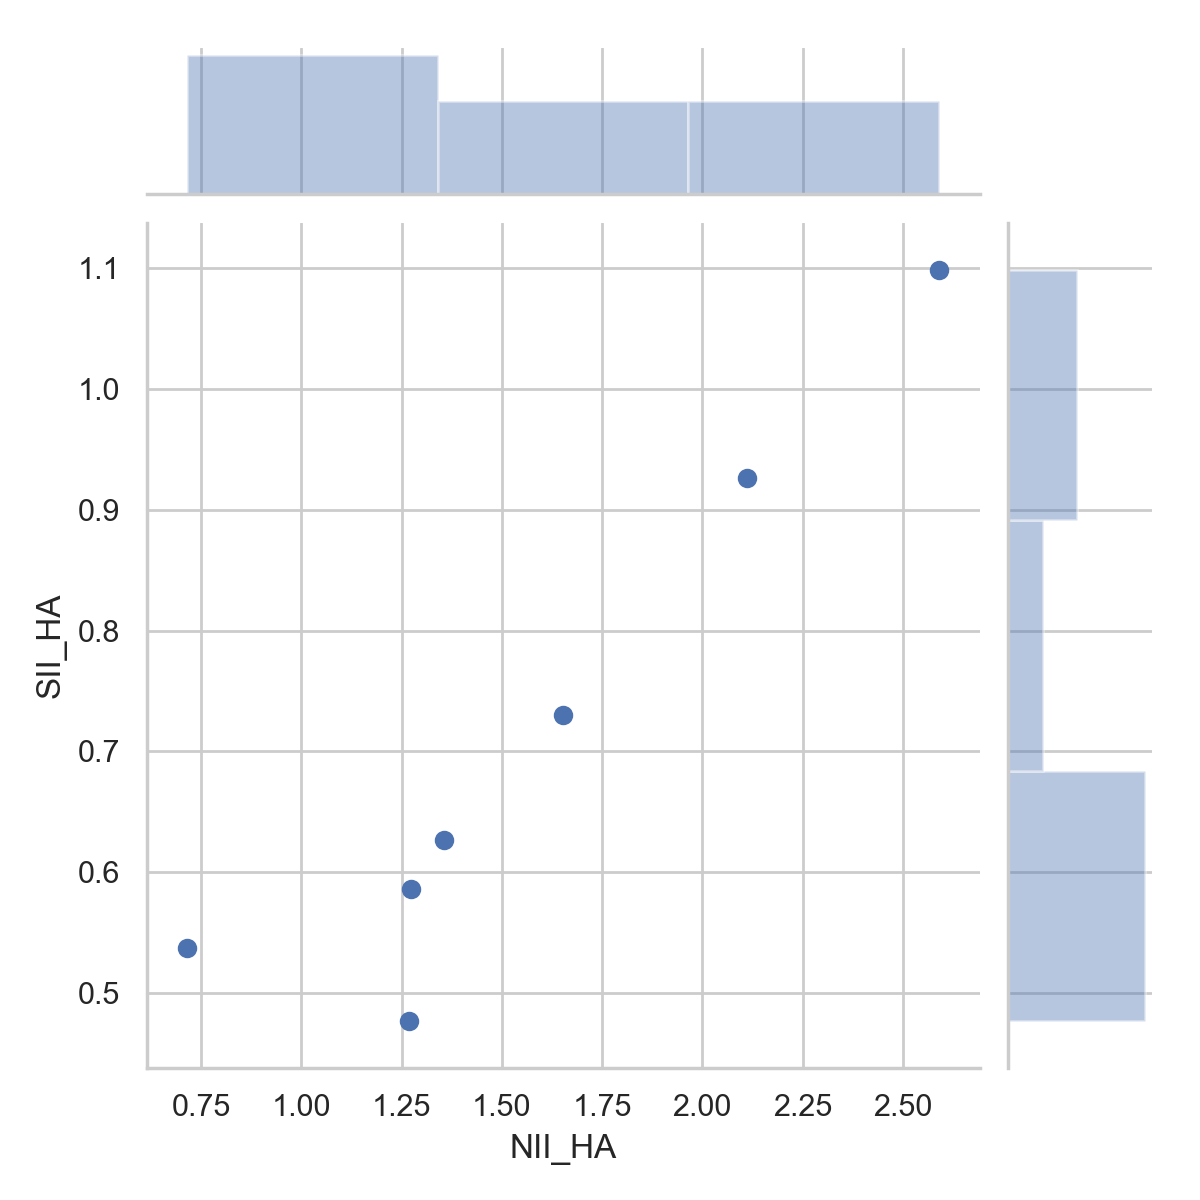

In [80]:
sns.jointplot(baade_data["NII_HA"][sigma_mask], baade_data["SII_HA"][sigma_mask])

In [75]:
maxnii_arg = np.argmax(baade_data["NII_HA"])

In [76]:
baade_data[maxnii_arg]

GAL-LON,GAL-LAT,Galcen_x [3],Galcen_y [3],Galcen_z [3],Vrange [2],HA,HA_ERR,HA_SIGMA_LEVEL,HB,HB_ERR,HB_SIGMA_LEVEL,NII,NII_ERR,NII_SIGMA_LEVEL,SII,SII_ERR,SII_SIGMA_LEVEL,OIII,OIII_ERR,OIII_SIGMA_LEVEL,NII_HA,NII_HA_ERR,SII_HA,SII_HA_ERR,OIII_HB,OIII_HB_ERR
deg,deg,kpc,kpc,kpc,km / s,R,R,,R,R,,R,R,,R,R,,R,R,,erg,erg,erg,erg,erg,erg
float32,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
3.4284,-2.55027,-0.926843281943 .. -0.739338891916,0.409202026798 .. 0.484767510737,-0.369248176498 .. -0.291829636093,-110.0 .. -50.0,0.0229854,0.0315378,0.72882,0.0596189,0.0694073,0.858971,0.704015,0.16508,4.26469,0.440696,0.154495,2.8525,0.0774368,0.0688856,1.12414,30.7231,42.7657,19.6204,27.7857,1.33779,1.96007


In [81]:
baade_data.write("LINE_RATIO_DATA.fits")